# Top 3% Solution | 0.976518, easy is all you need

## 参考資料

* https://www.kaggle.com/code/hzning/top-3-solution-0-976518-easy-is-all-you-need

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use("seaborn-v0_8-darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font",size="15")

In [26]:
# import data
train_df = pd.read_csv("../data/input/train.csv")
datasert_df = pd.read_csv("../data/input/train.csv")
test_df = pd.read_csv("../data/input/test.csv")

# check data
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [27]:
numeric_df = train_df.select_dtypes(include='number').drop(columns=['id'])
numeric_df.corr()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
Time_spent_Alone,1.000000,-0.628806,-0.640884,-0.598014,-0.611544
Social_event_attendance,-0.628806,1.000000,0.585224,0.566675,0.566679
Going_outside,-0.640884,0.585224,1.000000,0.549864,0.579305
Friends_circle_size,-0.598014,0.566675,0.549864,1.000000,0.522272
Post_frequency,-0.611544,0.566679,0.579305,0.522272,1.000000


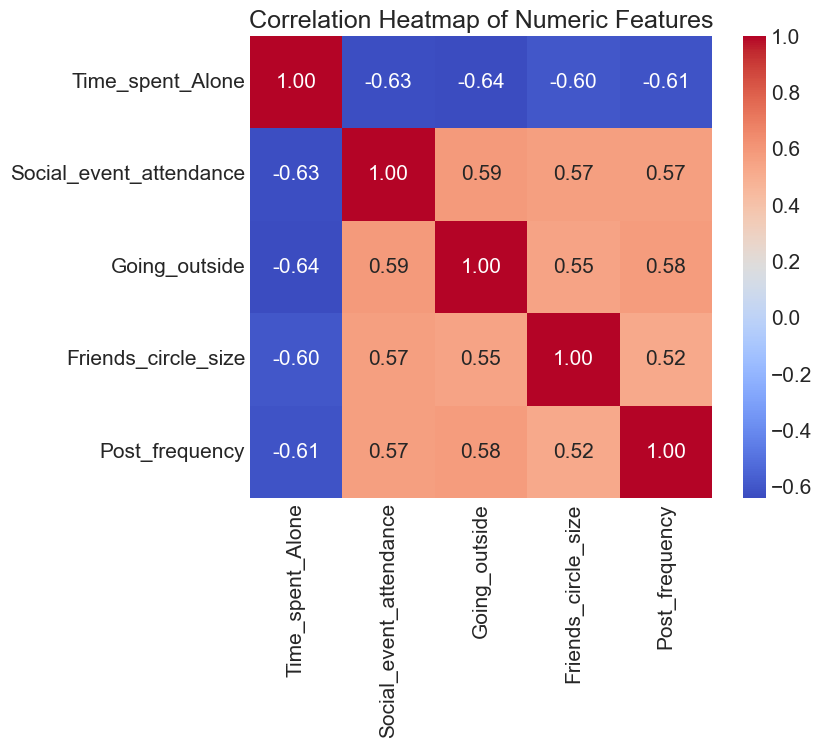

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [29]:
train_ID = train_df['id']
test_ID = test_df['id']

# drop unnecessary columns (id)
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

ntrain = train_df.shape[0]
ntest = test_df.shape[0]
# CAUTION: reverse 0 and 1 from the original Kaggle notebook
y_train = train_df['Personality'].map({'Extrovert': 0, 'Introvert': 1}).values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data = all_data.drop(columns=['Personality'])

# chell all_data
all_data.head()
all_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24699 entries, 0 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           23084 non-null  float64
 1   Stage_fear                 22208 non-null  object 
 2   Social_event_attendance    23122 non-null  float64
 3   Going_outside              22767 non-null  float64
 4   Drained_after_socializing  23118 non-null  object 
 5   Friends_circle_size        23295 non-null  float64
 6   Post_frequency             23027 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.3+ MB


## 欠損値の補完

まず`Time_spent_Alone`と負の相関がある`Social_event_attendance`を使用して欠損値を埋める。 <br>
その際`Social_event_attendance`を四分位数を使用して4つのグループに分ける。 <br>
その後、`Time_spent_Alone`をそれぞれのグループの値を使用して欠損値を埋める。 <br>

In [30]:
# create a new grouping column based on the quartiles of 'Social_event_attendance'
all_data['Social_attend_bin'] = pd.qcut(
        all_data['Social_event_attendance'],
        q = [0, 0.25, 0.5, 0.75, 1.0],
        labels = ['Q1', 'Q2', 'Q3', 'Q4']
)

# define a function to fill missing values in 'Time_spent_Alone' with the median within each group
def fill_by_group_median(df, group_col, target_col):
    return df[target_col].fillna(df.groupby(group_col)[target_col].transform('median'))

# apply the function to fill missing values in 'Time_spent_Alone'
all_data['Time_spent_Alone'] = fill_by_group_median(all_data,
                                                     group_col='Social_attend_bin',
                                                     target_col='Time_spent_Alone')

# check the filled values
all_data['Time_spent_Alone'].isnull().sum()

all_data = all_data.drop(columns=['Social_attend_bin'])

all_data.head()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24699 entries, 0 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           24648 non-null  float64
 1   Stage_fear                 22208 non-null  object 
 2   Social_event_attendance    23122 non-null  float64
 3   Going_outside              22767 non-null  float64
 4   Drained_after_socializing  23118 non-null  object 
 5   Friends_circle_size        23295 non-null  float64
 6   Post_frequency             23027 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.3+ MB


`Time_spent_Alone`にはまだ欠損値が存在している。 <br>
これは`Time_spent_Alone`と`Social_event_attendance`が共に欠損となっているものが存在しているためである。 <br>
`Going_outsite`も`Time_spent_Alone`と相関があるので、先ほどと同様の方法で欠損値を埋める。


In [31]:
all_data['Going_outside_bin'] = pd.qcut(
        all_data['Going_outside'],
        q = [0, 0.25, 0.5, 0.75, 1.0],
        labels = ['Q1', 'Q2', 'Q3', 'Q4']
)

all_data['Time_spent_Alone'] = fill_by_group_median(all_data,
                                                     group_col='Going_outside_bin',
                                                     target_col='Time_spent_Alone')

all_data.drop(columns=['Going_outside_bin'], inplace=True)

all_data['Time_spent_Alone'].isnull().sum()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24699 entries, 0 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           24699 non-null  float64
 1   Stage_fear                 22208 non-null  object 
 2   Social_event_attendance    23122 non-null  float64
 3   Going_outside              22767 non-null  float64
 4   Drained_after_socializing  23118 non-null  object 
 5   Friends_circle_size        23295 non-null  float64
 6   Post_frequency             23027 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.3+ MB


欠損値がなくなったことが確認できる。

それ以外についても欠損値を埋めるようにする。

In [32]:
def fill_missing_by_quantile_group(df, group_source_col, target_col, quantiles=[0, 0.25, 0.5, 0.75, 1.0], labels=None):
    """
        Fill missing values in `target_col` by grouping based on the quantiles of `group_source_col`, and using the median of each group to impute missing values.

        **Parameters:**
        - `df` (`pd.DataFrame`): The original dataset
        - `group_source_col` (`str`): The numeric column used for grouping
        - `target_col` (`str`): The target column with missing values to be filled
        - `quantiles` (`list`): Quantile breakpoints for grouping (default is quartiles)
        - `labels` (`list`): Labels for each group (default is auto-generated as Q1/Q2/...)

        **Returns:**
        - `pd.DataFrame`: The DataFrame with missing values filled (modifies in place)

    """
    if labels is None:
        labels = [f'Q{i+1}' for i in range(len(quantiles) - 1)]

    temp_bin_col = f'{group_source_col}_bin'

    df[temp_bin_col] = pd.qcut(
        df[group_source_col],
        q=quantiles,
        labels=labels
    )

    df[target_col] = df[target_col].fillna(df.groupby(temp_bin_col)[target_col].transform('median'))
    df.drop(columns=[temp_bin_col], inplace=True)

    return df

In [33]:
# [group_source_col, target_col] pairs to fill missing values
list_of_cols = [
    ('Going_outside', 'Social_event_attendance'),
    ('Friends_circle_size', 'Social_event_attendance'),
    ('Post_frequency', 'Social_event_attendance'),
    ('Social_event_attendance', 'Going_outside'),
    ('Post_frequency', 'Friends_circle_size'),
    ('Going_outside', 'Friends_circle_size'),
    ('Friends_circle_size', 'Post_frequency')
]

for group_source_col, target_col in list_of_cols:
    all_data = fill_missing_by_quantile_group(
        df=all_data,
        group_source_col=group_source_col,
        target_col=target_col
    )

all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24699 entries, 0 to 24698
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           24699 non-null  float64
 1   Stage_fear                 22208 non-null  object 
 2   Social_event_attendance    24699 non-null  float64
 3   Going_outside              24699 non-null  float64
 4   Drained_after_socializing  23118 non-null  object 
 5   Friends_circle_size        24699 non-null  float64
 6   Post_frequency             24699 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.3+ MB


## plot

<Axes: >

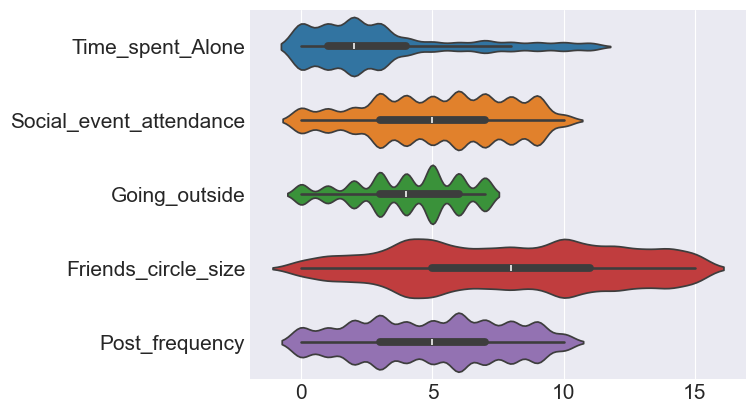

In [34]:
numeric_all_data = all_data.select_dtypes(include='number')
sns.violinplot(data=numeric_all_data, orient='h')

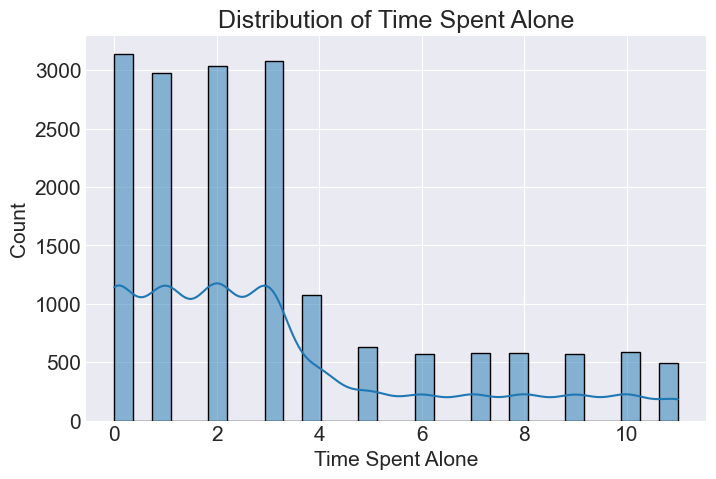

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Time_spent_Alone'], kde=True, bins=30)
plt.title('Distribution of Time Spent Alone')
plt.xlabel('Time Spent Alone')
plt.show()

## カテゴリカル特徴量

In [36]:
all_data = pd.get_dummies(all_data,
                          columns=['Stage_fear', 'Drained_after_socializing'],
                          prefix=['Stage', 'Drained']
                          )
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24699 entries, 0 to 24698
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Time_spent_Alone         24699 non-null  float64
 1   Social_event_attendance  24699 non-null  float64
 2   Going_outside            24699 non-null  float64
 3   Friends_circle_size      24699 non-null  float64
 4   Post_frequency           24699 non-null  float64
 5   Stage_No                 24699 non-null  bool   
 6   Stage_Yes                24699 non-null  bool   
 7   Drained_No               24699 non-null  bool   
 8   Drained_Yes              24699 non-null  bool   
dtypes: bool(4), float64(5)
memory usage: 1.0 MB


In [37]:
all_data.head()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_No,Stage_Yes,Drained_No,Drained_Yes
0,0.0,6.0,4.0,15.0,5.0,True,False,True,False
1,1.0,7.0,3.0,10.0,8.0,True,False,True,False
2,6.0,1.0,0.0,3.0,0.0,False,True,False,False
3,3.0,7.0,3.0,11.0,5.0,True,False,True,False
4,1.0,4.0,4.0,13.0,6.0,True,False,True,False


## モデルによる学習

ここでは分類問題において、よく使用される6つのモデルを選択する。 <br>
* L1-regularized Logistic Regression
* Elastic Net
* Support Vector Machine (SVM)
* Gradient Boosting Classifier
* XGBoost Classifier
* LightGBM Classifier <br><br>
$(\text{XGBoost}), (\text{LightGBM}) \in (\text{Gradiant Boosting Classifier})$な気がするが元のKaggle Notebookでは別物として取り扱っていそう。

### モデルの選択とアンサンブル平均

とりあえず使ってみる。
理論はその後勉強する方向で

In [38]:
#! pip install catboost

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [40]:
X_train = all_data[:ntrain]
X_test = all_data[ntrain:]
X = X_train
y = y_train

In [41]:
class_0 = y_train.sum()
class_1 = len(y_train) - class_0
scale_pos_weight = class_1 / class_0

In [42]:
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.01,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=0
)

cat = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    class_weights=[scale_pos_weight, 1.0],
    random_seed=42,
    verbose=0
)

lgbm = LGBMClassifier(
    num_leaves=31,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight={0: scale_pos_weight, 1: 1.0},
    random_state=42,
    verbose=0
)

In [43]:
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgbm', lgbm)
    ],
    voting='soft',
)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
ensemble.fit(X_train, y_train)

,estimators,"[('xgb', ...), ('cat', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [45]:
# optimize threshold
val_probs = ensemble.predict_proba(X_val)[:, 1]
best_threshold = 0.5
best_acc = 0.0

for threshold in np.arange(0.4, 0.6, 0.01):
    val_preds = (val_probs >= threshold).astype(int)
    acc = accuracy_score(y_val, val_preds)

    if acc > best_acc:
        best_acc = acc
        best_threshold = threshold

print(f"Best threshold: {best_threshold}, Best accuracy: {best_acc}")

Best threshold: 0.4700000000000001, Best accuracy: 0.9721997300944669


In [46]:
# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 元のデータセット全体を使用してクロスバリデーション
cv_scores = cross_val_score(ensemble, X, y, cv=cv, scoring='accuracy')

print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# 各個別モデルのクロスバリデーションも実行
print("\n--- Individual Model CV Scores ---")
models = [
    ('XGBoost', xgb),
    ('CatBoost', cat),
    ('LightGBM', lgbm)
]

for name, model in models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Cross Validation Scores: [0.96977058 0.96707152 0.9659919  0.97031039 0.97138229]
Mean CV Score: 0.9689
Standard Deviation: 0.0020

--- Individual Model CV Scores ---
XGBoost: 0.9691 (+/- 0.0037)
CatBoost: 0.9671 (+/- 0.0047)
LightGBM: 0.9658 (+/- 0.0057)


In [47]:
test_probs = ensemble.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

# create submission file
submission = pd.DataFrame({
    'id': test_ID,
    'Personality': test_preds
})

print(submission.head())
submission['Personality'] = submission['Personality'].map({0: 'Extrovert', 1: 'Introvert'})
submission.to_csv('../data/output/submission_ensemble.csv', index=False)

      id  Personality
0  18524            0
1  18525            1
2  18526            0
3  18527            0
4  18528            1


In [48]:
#!kaggle competitions submit -c playground-series-s5e7 -f ../data/output/submission_ensemble.csv -m "My Ensemble Classifier"

## アンサンブルするモデルを追加する

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [50]:
lr_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42,
    verbose=0
)

lr_enet = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000,
    random_state=42,
    verbose=0
)

svm_rbf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    verbose=0
)

In [51]:
voting = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cat', cat),
        ('lgbm', lgbm),
        ('lr_l1', lr_l1),
        ('lr_enet', lr_enet),
        ('svm_rbf', svm_rbf)
    ],
    voting='soft',
)

In [52]:
voting.fit(X_train, y_train)

,estimators,"[('xgb', ...), ('cat', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [53]:
# optimize threshold
val_probs = voting.predict_proba(X_val)[:, 1]
best_threshold_voting = 0.5
best_acc_voting = 0.0

for threshold in np.arange(0.4, 0.6, 0.01):
    val_preds = (val_probs >= threshold).astype(int)
    acc = accuracy_score(y_val, val_preds)

    if acc > best_acc_voting:
        best_acc_voting = acc
        best_threshold_voting = threshold

print(f"Best threshold: {best_threshold_voting}, Best accuracy: {best_acc_voting}")

Best threshold: 0.45000000000000007, Best accuracy: 0.9721997300944669


In [54]:
# Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 元のデータセット全体を使用してクロスバリデーション
cv_scores = cross_val_score(voting, X, y, cv=cv, scoring='accuracy')

print(f"Cross Validation Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# 各個別モデルのクロスバリデーションも実行
print("\n--- Individual Model CV Scores ---")
models = [
    ('XGBoost', xgb),
    ('CatBoost', cat),
    ('LightGBM', lgbm),
    ('Logistic Regression L1', lr_l1),
    ('Logistic Regression ElasticNet', lr_enet),
    ('SVM RBF', svm_rbf)
]

for name, model in models:
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

Cross Validation Scores: [0.97031039 0.96788124 0.96626181 0.9708502  0.97084233]
Mean CV Score: 0.9692
Standard Deviation: 0.0018

--- Individual Model CV Scores ---
XGBoost: 0.9691 (+/- 0.0037)
CatBoost: 0.9671 (+/- 0.0047)
LightGBM: 0.9658 (+/- 0.0057)
Logistic Regression L1: 0.9690 (+/- 0.0033)
Logistic Regression ElasticNet: 0.9690 (+/- 0.0033)
SVM RBF: 0.9689 (+/- 0.0036)


In [55]:
test_probs_voting = voting.predict_proba(X_test)[:, 1]
test_preds_voting = (test_probs_voting >= best_threshold_voting).astype(int)

# create submission file
submission_voting = pd.DataFrame({
    'id': test_ID,
    'Personality': test_preds_voting
})

print(submission_voting.head())
submission_voting['Personality'] = submission_voting['Personality'].map({0: 'Extrovert', 1: 'Introvert'})
submission_voting.to_csv('../data/output/submission_ensemble_6.csv', index=False)

      id  Personality
0  18524            0
1  18525            1
2  18526            0
3  18527            0
4  18528            1


In [ ]:
#!kaggle competitions submit -c playground-series-s5e7 -f ../data/output/submission_ensemble_6.csv -m "My Ensemble Classifier of 6 models"

100%|███████████████████████████████████████| 96.5k/96.5k [00:00<00:00, 110kB/s]
Successfully submitted to Predict the Introverts from the Extroverts

## Optunaによってハイパーパラメータチューニングを行う

In [57]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [optuna]2m5/6 [optuna]]


In [58]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
def buildensemble(trial) -> VotingClassifier:
    xgb = XGBClassifier(
        max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
        subsample=trial.suggest_float('xgb_subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
        objective="binary:logistic",
        learning_rate=0.01,
        n_estimators=1000,
        random_state=42,
        verbose=0
    )

    cat = CatBoostClassifier(
        iterations=trial.suggest_int('cat_iterations', 100, 1000, step=100),
        depth=trial.suggest_int('cat_depth', 4, 10),
        class_weights=[scale_pos_weight, 1.0],
        l2_leaf_reg=trial.suggest_float('cat_l2_leaf_reg', 1e-5, 10.0, log=True),
        loss_function='Logloss',
        learning_rate=0.01,
        random_seed=42,
        verbose=0
    )

    lgbm = LGBMClassifier(
        max_depth=trial.suggest_int('lgbm_max_depth', 3, 10),
        subsample=trial.suggest_float('lgbm_subsample', 0.5, 1.0),
        colsample_bytree=trial.suggest_float('lgbm_colsample_bytree', 0.5, 1.0),
        class_weight={0: scale_pos_weight, 1: 1.0},
        learning_rate=0.01,
        n_estimators=1000,
        random_state=42,
        verbose=0
    )

    lr_l1 = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=trial.suggest_float('lr_l1_C', 1e-5, 10.0, log=True),
        max_iter=1000,
        random_state=42,
        verbose=0
    )

    lr_enet = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=trial.suggest_float('lr_enet_l1_ratio', 0.0, 1.0),
        C=trial.suggest_float('lr_enet_C', 1e-5, 10.0, log=True),
        max_iter=1000,
        random_state=42,
        verbose=0
    )

    svm_rbf = SVC(
        kernel='rbf',
        C=trial.suggest_float('svm_rbf_C', 1e-5, 10.0, log=True),
        gamma=trial.suggest_categorical('svm_rbf_gamma', ['scale', 'auto']),
        probability=True,
        random_state=42,
        verbose=0
    )

    ensemble = VotingClassifier(
        estimators=[
            ('xgb', xgb),
            ('cat', cat),
            ('lgbm', lgbm),
            ('lr_l1', lr_l1),
            ('lr_enet', lr_enet),
            ('svm_rbf', svm_rbf)
        ],
        voting='soft',
    )

    return ensemble

In [60]:
def objective(trial):
    model = buildensemble(trial)
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy')
    return scores.mean()


In [61]:
sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=500, show_progress_bar=True)

print('best_trial:', study.best_trial)
print('best_params:', study.best_params)

best_model = buildensemble(study.best_trial)
best_model.fit(X_train, y_train)

[I 2025-07-31 18:46:12,747] A new study created in memory with name: no-name-d69546a4-cd7a-4f3b-9404-99951ea59556
  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/500 [00:25<?, ?it/s]


[W 2025-07-31 18:46:38,666] Trial 0 failed with parameters: {'xgb_max_depth': 5, 'xgb_subsample': 0.9753571532049581, 'xgb_colsample_bytree': 0.8659969709057025, 'cat_iterations': 600, 'cat_depth': 5, 'cat_l2_leaf_reg': 8.629132190071849e-05, 'lgbm_max_depth': 3, 'lgbm_num_leaves': 46, 'lgbm_subsample': 0.8005575058716043, 'lgbm_colsample_bytree': 0.8540362888980227, 'lr_l1_C': 1.3289448722869181e-05, 'lr_enet_l1_ratio': 0.9699098521619943, 'lr_enet_C': 0.9877700294007905, 'svm_rbf_C': 0.00018794668241638458, 'svm_rbf_gamma': 'auto'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/kazuki/Documents/Kaggle/.kaggle/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/xq/bpxwdpg112n7q8kn_d1dbjg80000gn/T/ipykernel_25818/4146435216.py", line 3, in objective
    scores = cross_val_score(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=

KeyboardInterrupt: 